In [33]:
import numpy as np
import json
import csv

data = np.genfromtxt('../data/all_samples_both_instruments_filtered.csv', delimiter=',', skip_header=True)
data = data[:, 1:]
data[np.where(data == 0)] = -1
data[np.where(data > 0)] = 1
data[np.where(np.isnan(data))] = 0
print(data)
m, n = data.shape

Z = np.genfromtxt('../data/impute_logloss_realfill_Z5.csv', delimiter=',', skip_header=True)
Z = Z[:, 1:]
Z[np.where(Z == 0)] = -1

adir_indices = 1:77
ados_indices = 78:n

ados_Z = np.genfromtxt('../data/impute_logloss_ados_realfill_Z3.csv', delimiter=',', skip_header=True)
ados_Z = ados_Z[:, 1:]
ados_Z[np.where(ados_Z == 0)] = -1
ados_n = ados_Z.shape[1]

adir_data = data[:,:adir_n]
ados_data = data[:, adir_n:]

with open('../data/all_samples_both_instruments_filtered_labels.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    key_to_index = dict([(h, i) for i, h in enumerate(header[1:])])
    data_labels = [x[1:] for x in reader]
    
def get_label(i, key):
    return data_labels[i][key_to_index[key]]
        
print(get_label(0, 'ADIR:diagnosis'))

//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


[[ 0. -1.  1. ..., -1.  1.  1.]
 [ 0. -1.  1. ...,  1.  1.  1.]
 [ 0.  0.  0. ...,  1. -1. -1.]
 ..., 
 [-1.  0. -1. ..., -1. -1. -1.]
 [-1.  0. -1. ..., -1. -1. -1.]
 [-1.  0. -1. ...,  1. -1. -1.]]
Autism


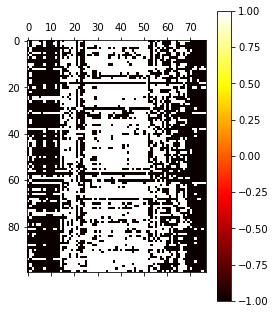

In [31]:
import matplotlib.pyplot as plt
cay = plt.matshow(adir_Z[:100, :], cmap='hot')
plt.colorbar(cay)
plt.show()

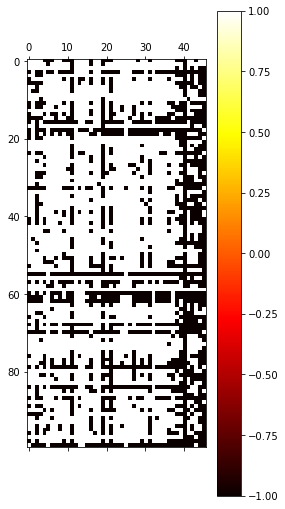

In [32]:
cay = plt.matshow(ados_Z[:100, :], cmap='hot')
plt.colorbar(cay)
plt.show()

In [25]:
import random
train_indices = np.array(random.sample(range(m), int(.9*m)))
test_indices = np.array(list(set(range(m)) - set(train_indices)))
print(train_indices.shape, test_indices.shape)

(8190,) (910,)


In [45]:
from sklearn.linear_model import LogisticRegression

train_errors = []
test_errors = []
train_correct = 0
train_attempts = 0
test_correct = 0
test_attempts = 0
for i in range(ados_Z.shape[1]):
    train_data = adir_Z[train_indices, :]
    test_data = adir_Z[test_indices, :]
    train_y = ados_Z[train_indices, i]
    test_y = ados_Z[test_indices, i]
    real_train_y = ados_data[train_indices, i]
    real_test_y = ados_data[test_indices, i]
    
    model = LogisticRegression(fit_intercept=False)
    model.fit(train_data, train_y)
    
    train_predictions = model.predict(train_data[real_train_y != 0])
    train_num_correct = sum([x for x in train_predictions * real_train_y[real_train_y != 0] if x == 1])
    train_num_attempts = train_predictions.shape[0]
    train_errors.append(1.0*train_num_correct/train_num_attempts)
    train_correct += train_num_correct
    train_attempts += train_num_attempts
    
    test_predictions = model.predict(test_data[real_test_y != 0])
    test_num_correct = sum([x for x in test_predictions * real_test_y[real_test_y != 0] if x == 1])
    test_num_attempts = test_predictions.shape[0]
    test_errors.append(1.0*test_num_correct/test_num_attempts)
    test_correct += test_num_correct
    test_attempts += test_num_attempts

    print(train_errors[-1], test_errors[-1], train_num_attempts, test_num_attempts)
print('Average Accuracy', 1.0*train_correct/train_attempts, 1.0*test_correct/test_attempts)
    
    
    

0.732468180684 0.711086226204 8014 893
0.878437624552 0.873659117998 7527 839
0.729800774765 0.716770186335 7228 805
0.781056135573 0.789687924016 6609 737
0.61386374464 0.585567010309 4198 485
0.762505955217 0.779381443299 4198 485
0.828025477707 0.812807881773 3768 406
0.638318203536 0.61215932914 4186 477
0.828561138124 0.838499184339 5553 613
0.722093323021 0.704176334107 7758 862
0.932367149758 0.921568627451 2277 255
0.645833333333 0.609958506224 2064 241
0.746774193548 0.725806451613 620 62
0.847285067873 0.850678733032 7956 884
0.874371227364 0.870894677237 7952 883
0.698428290766 0.666666666667 1018 117
0.654139156932 0.622727272727 7876 880
0.830431671834 0.818181818182 4193 484
0.899618502623 0.896694214876 4194 484
0.618417570786 0.620098039216 3779 408
0.883324453916 0.877805486284 3754 401
0.720274189296 0.686131386861 3793 411
0.833554552694 0.817733990148 3767 406
0.863636363636 0.6 44 10
0.70570623459 0.701112877583 5678 629
0.909719602666 0.909502262443 7953 884
0.862

In [44]:
from sklearn.linear_model import LogisticRegression

train_errors = []
test_errors = []
train_correct = 0
train_attempts = 0
test_correct = 0
test_attempts = 0
for i in range(adir_Z.shape[1]):
    train_data = ados_Z[train_indices, :]
    test_data = ados_Z[test_indices, :]
    train_y = adir_Z[train_indices, i]
    test_y = adir_Z[test_indices, i]
    real_train_y = adir_data[train_indices, i]
    real_test_y = adir_data[test_indices, i]
    
    model = LogisticRegression(fit_intercept=False)
    model.fit(train_data, train_y)
    
    train_predictions = model.predict(train_data[real_train_y != 0])
    train_num_correct = sum([x for x in train_predictions * real_train_y[real_train_y != 0] if x == 1])
    train_num_attempts = train_predictions.shape[0]
    train_errors.append(1.0*train_num_correct/train_num_attempts)
    train_correct += train_num_correct
    train_attempts += train_num_attempts
    
    test_predictions = model.predict(test_data[real_test_y != 0])
    test_num_correct = sum([x for x in test_predictions * real_test_y[real_test_y != 0] if x == 1])
    test_num_attempts = test_predictions.shape[0]
    test_errors.append(1.0*test_num_correct/test_num_attempts)
    test_correct += test_num_correct
    test_attempts += test_num_attempts

    print(train_errors[-1], test_errors[-1], train_num_attempts, test_num_attempts)
print('Average Accuracy', 1.0*train_correct/train_attempts, 1.0*test_correct/test_attempts)
    
    
    

0.813216656608 0.8 6628 745
0.714695752009 0.734299516908 1742 207
0.818767123288 0.815136476427 7300 806
0.826614001634 0.841911764706 7342 816
0.950842696629 0.949790794979 6408 717
0.924013495673 0.92005242464 6817 763
0.743328100471 0.74025974026 1274 154
0.757125712571 0.737333333333 6666 750
0.957456404089 0.949265687583 6652 749
0.948356102687 0.949129852744 6661 747
0.942731943185 0.934316353887 6618 746
0.929771908764 0.931726907631 6664 747
0.781163006496 0.76275862069 6466 725
0.769095182139 0.747572815534 1702 206
0.674764181419 0.655172413793 7739 870
0.848871807587 0.852842809365 8066 897
0.690010167768 0.664009111617 7868 878
0.612945406996 0.597968069666 6118 689
0.839919417325 0.829370629371 6453 715
0.926754987056 0.925207756233 6567 722
0.961687170475 0.966876971609 5690 634
0.652409830833 0.65 6266 700
0.657700508447 0.627565982405 6097 682
0.650031786395 0.61087267525 6292 699
0.580670799555 0.57 6291 700
0.861373250895 0.871201157742 6146 691
0.650734038921 0.6575